# PID Synergy Matrices — sklearn Dataset Preparation

This notebook demonstrates how to load and format sklearn built-in datasets for **PID (Partial Information Decomposition) synergy matrix computation**, timing scalability assessment, MI comparison, and cross-subsample stability analysis.

**Datasets included:**
- **Iris** (150×4): 3-class, classic benchmark, baseline
- **Wine** (178×13): 3-class, chemical domain, interpretable interactions
- **Breast Cancer** (569×30): Binary, medical domain, timing scalability
- **Diabetes Binarized** (442×10): Binary, medical domain, binarized regression

Each sample is converted to a JSON example with feature-value input, string target output, and metadata fields (fold assignment, feature names, task type, n_classes, row index).

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab; install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1', 'matplotlib==3.10.0', 'tabulate==0.9.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import (
    load_breast_cancer,
    load_diabetes,
    load_iris,
    load_wine,
)
from sklearn.model_selection import KFold
from tabulate import tabulate

## Load Pre-computed Demo Data

Load a curated mini subset (50 examples across 4 datasets) from the GitHub repository, with local file fallback.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/dataset_iter1_pid_synergy_mat/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} datasets, "
      f"{sum(len(d['examples']) for d in data['datasets'])} total examples")

Loaded 4 datasets, 50 total examples


## Configuration

Tunable parameters for dataset processing. These control fold assignment and which datasets to process.

In [5]:
# ---------- Config ----------
N_FOLDS = 5           # Number of cross-validation folds
RANDOM_STATE = 42     # Random seed for reproducibility
# Which datasets to load from sklearn (all 4 used in full pipeline)
DATASET_NAMES = ["breast_cancer", "wine", "iris", "diabetes_binarized"]

## Helper Functions

Fold assignment via KFold and dataset-to-schema conversion, copied from the original `data.py` script.

In [6]:
def make_fold_assignments(n_samples: int, n_folds: int = N_FOLDS, random_state: int = RANDOM_STATE) -> list[int]:
    """Assign each sample to a fold using KFold."""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    folds = [0] * n_samples
    for fold_idx, (_, test_idx) in enumerate(kf.split(range(n_samples))):
        for idx in test_idx:
            folds[idx] = fold_idx
    return folds


def process_dataset(
    name: str,
    data: np.ndarray,
    target: np.ndarray,
    feature_names: list[str],
    target_names: list[str] | None,
    task_type: str,
    n_classes: int,
) -> dict:
    """Convert a sklearn dataset to schema-compliant format."""
    n_samples, n_features = data.shape
    folds = make_fold_assignments(n_samples)

    examples = []
    for i in range(n_samples):
        # Build input as JSON string of feature name→value pairs
        feature_dict = {}
        for j, fname in enumerate(feature_names):
            val = float(data[i, j])
            # Round to avoid excessive decimal places
            feature_dict[fname] = round(val, 6)

        input_str = json.dumps(feature_dict)

        # Build output as string label
        if target_names is not None and task_type == "classification":
            output_str = str(target_names[int(target[i])])
        else:
            output_str = str(target[i])

        example = {
            "input": input_str,
            "output": output_str,
            "metadata_fold": folds[i],
            "metadata_feature_names": feature_names,
            "metadata_task_type": task_type,
            "metadata_n_classes": n_classes,
            "metadata_row_index": i,
            "metadata_n_features": n_features,
            "metadata_n_samples": n_samples,
        }
        examples.append(example)

    return {"dataset": name, "examples": examples}

## Load and Process All sklearn Datasets

Load the 4 sklearn datasets and convert each to the PID synergy analysis schema format.

In [7]:
def load_all_datasets() -> list[dict]:
    """Load 4 sklearn datasets for PID synergy analysis."""
    results = []

    # 1. Breast Cancer Wisconsin (Diagnostic) - 569 × 30, binary
    bc = load_breast_cancer()
    results.append(process_dataset(
        name="breast_cancer",
        data=bc.data,
        target=bc.target,
        feature_names=list(bc.feature_names),
        target_names=["malignant", "benign"],
        task_type="classification",
        n_classes=2,
    ))
    print(f"  breast_cancer: {len(results[-1]['examples'])} examples")

    # 2. Wine - 178 × 13, 3-class
    wine = load_wine()
    results.append(process_dataset(
        name="wine",
        data=wine.data,
        target=wine.target,
        feature_names=list(wine.feature_names),
        target_names=["class_0", "class_1", "class_2"],
        task_type="classification",
        n_classes=3,
    ))
    print(f"  wine: {len(results[-1]['examples'])} examples")

    # 3. Iris - 150 × 4, 3-class
    iris = load_iris()
    results.append(process_dataset(
        name="iris",
        data=iris.data,
        target=iris.target,
        feature_names=list(iris.feature_names),
        target_names=["setosa", "versicolor", "virginica"],
        task_type="classification",
        n_classes=3,
    ))
    print(f"  iris: {len(results[-1]['examples'])} examples")

    # 4. Diabetes (binarized at median) - 442 × 10, binary
    diab = load_diabetes()
    median_target = np.median(diab.target)
    binarized_target = (diab.target > median_target).astype(int)
    results.append(process_dataset(
        name="diabetes_binarized",
        data=diab.data,
        target=binarized_target,
        feature_names=list(diab.feature_names),
        target_names=["below_median", "above_median"],
        task_type="classification",
        n_classes=2,
    ))
    print(f"  diabetes_binarized: {len(results[-1]['examples'])} examples")

    return results


print("Loading sklearn datasets for PID synergy analysis...")
generated_datasets = load_all_datasets()
generated_output = {"datasets": generated_datasets}

total_examples = sum(len(d["examples"]) for d in generated_datasets)
print(f"\nTotal: {len(generated_datasets)} datasets, {total_examples} examples")

Loading sklearn datasets for PID synergy analysis...
  breast_cancer: 569 examples
  wine: 178 examples
  iris: 150 examples
  diabetes_binarized: 442 examples

Total: 4 datasets, 1339 examples


## Compare Generated vs Pre-computed Data

Verify that our freshly-generated data matches the pre-computed demo subset structure.

In [8]:
# Compare pre-computed (demo subset) with freshly generated data
print("=== Pre-computed demo data (loaded from JSON) ===")
for ds in data["datasets"]:
    ex0 = ds["examples"][0]
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples, "
          f"n_features={ex0['metadata_n_features']}, n_classes={ex0['metadata_n_classes']}")

print("\n=== Freshly generated data (from sklearn) ===")
for ds in generated_datasets:
    ex0 = ds["examples"][0]
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples, "
          f"n_features={ex0['metadata_n_features']}, n_classes={ex0['metadata_n_classes']}")

# Spot-check: verify first example of iris matches between demo and generated
demo_iris = [d for d in data["datasets"] if d["dataset"] == "iris"][0]
gen_iris = [d for d in generated_datasets if d["dataset"] == "iris"][0]
demo_first = json.loads(demo_iris["examples"][0]["input"])
gen_first = json.loads(gen_iris["examples"][0]["input"])
match = all(abs(demo_first[k] - gen_first[k]) < 1e-4 for k in demo_first)
print(f"\nSpot-check iris[0] input values match: {match}")

=== Pre-computed demo data (loaded from JSON) ===
  iris: 15 examples, n_features=4, n_classes=3
  wine: 15 examples, n_features=13, n_classes=3
  breast_cancer: 10 examples, n_features=30, n_classes=2
  diabetes_binarized: 10 examples, n_features=10, n_classes=2

=== Freshly generated data (from sklearn) ===
  breast_cancer: 569 examples, n_features=30, n_classes=2
  wine: 178 examples, n_features=13, n_classes=3
  iris: 150 examples, n_features=4, n_classes=3
  diabetes_binarized: 442 examples, n_features=10, n_classes=2

Spot-check iris[0] input values match: True


## Visualization: Dataset Summary & Feature Distributions

Overview of all 4 datasets: sample counts, feature dimensionality, class distributions, and example feature distributions.

| Dataset            |   Samples |   Features |   Classes | Class Labels                  |
|--------------------|-----------|------------|-----------|-------------------------------|
| breast_cancer      |       569 |         30 |         2 | benign, malignant             |
| wine               |       178 |         13 |         3 | class_0, class_1, class_2     |
| iris               |       150 |          4 |         3 | setosa, versicolor, virginica |
| diabetes_binarized |       442 |         10 |         2 | above_median, below_median    |


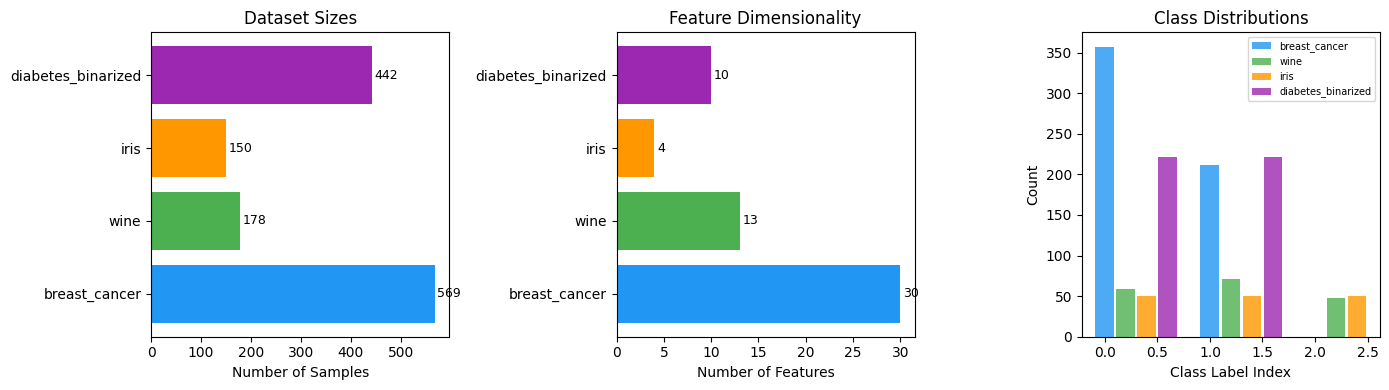

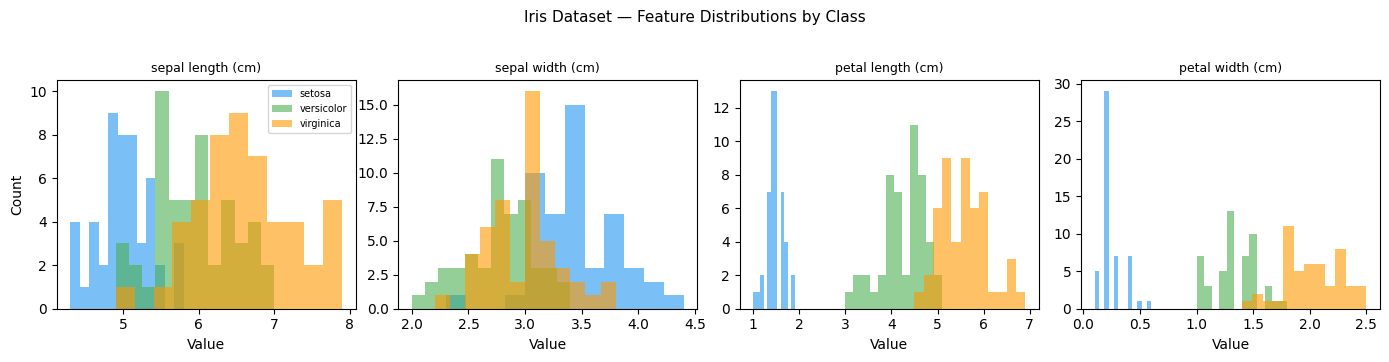


--- Fold Distribution per Dataset ---
| Dataset            |   Fold 0 |   Fold 1 |   Fold 2 |   Fold 3 |   Fold 4 |
|--------------------|----------|----------|----------|----------|----------|
| breast_cancer      |      114 |      114 |      114 |      114 |      113 |
| wine               |       36 |       36 |       36 |       35 |       35 |
| iris               |       30 |       30 |       30 |       30 |       30 |
| diabetes_binarized |       89 |       89 |       88 |       88 |       88 |


In [9]:
# --- Summary Table ---
summary_rows = []
for ds in generated_datasets:
    ex0 = ds["examples"][0]
    classes = sorted(set(e["output"] for e in ds["examples"]))
    summary_rows.append([
        ds["dataset"],
        len(ds["examples"]),
        ex0["metadata_n_features"],
        ex0["metadata_n_classes"],
        ", ".join(classes),
    ])

print(tabulate(
    summary_rows,
    headers=["Dataset", "Samples", "Features", "Classes", "Class Labels"],
    tablefmt="github",
))

# --- Figure 1: Bar chart of dataset sizes ---
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ds_names = [r[0] for r in summary_rows]
ds_samples = [r[1] for r in summary_rows]
ds_features = [r[2] for r in summary_rows]

colors = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0']

# Subplot 1: Number of samples
axes[0].barh(ds_names, ds_samples, color=colors)
axes[0].set_xlabel("Number of Samples")
axes[0].set_title("Dataset Sizes")
for i, v in enumerate(ds_samples):
    axes[0].text(v + 5, i, str(v), va='center', fontsize=9)

# Subplot 2: Number of features
axes[1].barh(ds_names, ds_features, color=colors)
axes[1].set_xlabel("Number of Features")
axes[1].set_title("Feature Dimensionality")
for i, v in enumerate(ds_features):
    axes[1].text(v + 0.3, i, str(v), va='center', fontsize=9)

# Subplot 3: Class distribution for each dataset
for idx, ds in enumerate(generated_datasets):
    class_counts = {}
    for e in ds["examples"]:
        class_counts[e["output"]] = class_counts.get(e["output"], 0) + 1
    labels = sorted(class_counts.keys())
    counts = [class_counts[l] for l in labels]
    x_pos = np.arange(len(labels)) + idx * 0.2
    axes[2].bar(x_pos, counts, width=0.18, label=ds["dataset"], color=colors[idx], alpha=0.8)

axes[2].set_xlabel("Class Label Index")
axes[2].set_ylabel("Count")
axes[2].set_title("Class Distributions")
axes[2].legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

# --- Figure 2: Feature value distributions for iris (4 features) ---
iris_ds = [d for d in generated_datasets if d["dataset"] == "iris"][0]
iris_features = iris_ds["examples"][0]["metadata_feature_names"]
iris_data_matrix = np.array([
    [json.loads(e["input"])[f] for f in iris_features]
    for e in iris_ds["examples"]
])
iris_labels = [e["output"] for e in iris_ds["examples"]]

fig, axes = plt.subplots(1, len(iris_features), figsize=(14, 3.5))
unique_labels = sorted(set(iris_labels))
label_colors = {'setosa': '#2196F3', 'versicolor': '#4CAF50', 'virginica': '#FF9800'}

for j, fname in enumerate(iris_features):
    for lbl in unique_labels:
        mask = [iris_labels[i] == lbl for i in range(len(iris_labels))]
        vals = iris_data_matrix[mask, j]
        axes[j].hist(vals, bins=12, alpha=0.6, label=lbl, color=label_colors.get(lbl, 'gray'))
    axes[j].set_title(fname, fontsize=9)
    axes[j].set_xlabel("Value")
    if j == 0:
        axes[j].set_ylabel("Count")
        axes[j].legend(fontsize=7)

fig.suptitle("Iris Dataset — Feature Distributions by Class", fontsize=11, y=1.02)
plt.tight_layout()
plt.show()

# --- Fold distribution ---
print("\n--- Fold Distribution per Dataset ---")
fold_rows = []
for ds in generated_datasets:
    fold_counts = {}
    for e in ds["examples"]:
        f = e["metadata_fold"]
        fold_counts[f] = fold_counts.get(f, 0) + 1
    row = [ds["dataset"]] + [fold_counts.get(i, 0) for i in range(N_FOLDS)]
    fold_rows.append(row)

print(tabulate(
    fold_rows,
    headers=["Dataset"] + [f"Fold {i}" for i in range(N_FOLDS)],
    tablefmt="github",
))